# Correlation analysis between spike trains

In [ ]:
import os
import neo
import pandas as pd
import numpy as np
import pint
import matplotlib.pyplot as plt
import elephant
from neo import SpikeTrain
%matplotlib inline

from quantities import ms, s, Hz
from elephant.spike_train_generation import homogeneous_poisson_process, homogeneous_gamma_process
from elephant.statistics import mean_firing_rate, isi, cv, time_histogram, instantaneous_rate
from elephant.kernels import GaussianKernel
from openpyxl import Workbook
import seaborn as sns
import matplotlib.pyplot as plt



# Correlation Coefficients (neurons)
#### adapted from Elephant toolkit


In [1]:
# calculation of Correlation Coefficients between pairs of sppiketrains (pairs of neurons or pairs of electrodes)
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import corrcoef
from elephant.spike_train_correlation import correlation_coefficient
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Define the directory containing the Excel files
directory_path = r'C:\Users\.....\Documents\Jupyter_MCS'
sampling_f = 25000  # Define the sampling frequency

# Get a list of all files in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]
print("CSV files found in the directory:")
for file in csv_files:
    print(file)

# Specify the output Excel file path
output_path = os.path.join(directory_path, 'Correlation_Matrix.xlsx')


# Using ExcelWriter to write to different sheets
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    
    # Create a new workbook object
    wb = Workbook()

    # Remove the default sheet created by openpyxl
    default_sheet = wb['Sheet']
    wb.remove(default_sheet)

    
    # Iterate over each .csv file ##############################################
    for file_name in csv_files:
        file_path = os.path.join(directory_path, file_name)
        print(f"\nProcessing file: {file_name}")

        if os.path.exists(file_path):
            print(f"File '{file_name}' exists.")
        else:
            print(f"File '{file_name}' does not exist.")
            continue

        try:
            df = pd.read_csv(file_path)
            # Exclude the first column
            df_updated = df.iloc[:, 1:]

            # Get neuron names and spike train data
            neuron_names = df_updated.columns.tolist()
            print("Neuron names:", neuron_names)
            raw_data = df_updated.values
            #print("Spike train data:", spike_train_data)

            # Divide spike train data by the sampling frequency
            spike_train = raw_data / sampling_f 

            # Create a new DataFrame with updated values
            df_new = pd.DataFrame(spike_train, columns=neuron_names)
            
            # generate nxn matrix to save corrcoef data
            num_neurons = len(df_new.columns)
            correlation_matrix = np.zeros((num_neurons, num_neurons))

            # Get the maximum time point across all neurons
            global_max_spike_time = (np.max(df_new.max()) + 1) * s
            t_start = 0 * s
            
            
            ################################## Process current file . Iterate over neurons ######################
            

            # Filter out NaN values which can occur if spike trains have different lengths
            spike_train_filtered = spike_train[~np.isnan(spike_train)]
            
            print(f"{file_name} is in process")
            
            for i in range(num_neurons):
                for j in range(i + 1, num_neurons):

                    # Get the spike trains for neuron i and j, filtering out NaN values
                    spike_train_i_filtered = df_new.iloc[:, i].dropna().values * s
                    spike_train_j_filtered = df_new.iloc[:, j].dropna().values * s

                    # Here you access the neuron names for i and j
                    neuron_name_i = neuron_names[i]
                    neuron_name_j = neuron_names[j]
                    #print(f"Calculating correlation between {neuron_name_i} and {neuron_name_j}...")

                    spike_train_i = SpikeTrain(spike_train_i_filtered, t_start=0 *s, t_stop=global_max_spike_time)
                    spike_train_j = SpikeTrain(spike_train_j_filtered, t_start=0 *s, t_stop=global_max_spike_time) 
                    #print(f"spike-train i of neuron {neuron_name_i}", spike_train_i)
                    #print(f"spike-train j of neuron {neuron_name_j}", spike_train_j)

                    # Create BinnedSpikeTrain objects with explicit t_start and t_stop
                    binned_spike_train_i = BinnedSpikeTrain([spike_train_i], bin_size=0.01 *s, 
                                                            t_start=0.0 *s, t_stop=global_max_spike_time, tolerance=None)
                    binned_spike_train_j = BinnedSpikeTrain([spike_train_j], bin_size=0.01 *s, 
                                                            t_start=0.0 *s, t_stop=global_max_spike_time, tolerance=None)
                    #print (f"binned_spike_train_i of neuron {neuron_name_i}:",binned_spike_train_i)
                    #print (f"binned_spike_train_j of neuron {neuron_name_j}:",binned_spike_train_j)

                    # Calculate correlation coefficient between spike trains
                    cc_matrix = corrcoef(BinnedSpikeTrain([spike_train_i, spike_train_j], bin_size=0.01 *s, tolerance=None))
                    #print(f" cc of Neuron {i} and Neuron {j} is:  {cc_matrix[0, 1]}")
                    

                    # Store the result in the matrix (symmetric matrix)
                    correlation_matrix[i, j] = cc_matrix[0, 1]
                    correlation_matrix[j, i] = cc_matrix[0, 1]

               

            print(f"Correlation matrix of {file_name}:", correlation_matrix)
            print(f"#################################################################")
            
            correlation_matrix_df = pd.DataFrame(correlation_matrix, index=neuron_names, columns=neuron_names) 
            
            
            
            ################# Write to Excel sheet ########################################################
            
            # Write the correlation matrix to a new sheet in the Excel workbook
            # Generate a valid sheet name (truncate if necessary)
            sheet_name = file_name [:-4][23:43]  # Use characters 24 to 43 as sheet name. (remove '.csv'). Max 31 letters 

            # Write the DataFrame to a new sheet in the Excel workbook
            correlation_matrix_df.to_excel(writer, sheet_name=sheet_name, index=True)
            
            
            ################# Plot corelation matrix ########################################################
            
            print(f"######################### {file_name}, correlation Matrix Heatmap #################")
            
            # Set the style of the visualization
            sns.set_theme(style='white')

            # Create a larger figure to better accommodate the heatmap
            plt.figure(figsize=(10, 8))

            # Generate the heatmap
            ax = sns.heatmap(correlation_matrix_df,
                             cmap='coolwarm',        # A good color map for divergence
                             annot=False,             # Enable annotations to display correlation values
                             fmt=".2f",              # Format for the annotations
                             linewidths=0.5,         # Line widths between squares
                             cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.5}, # Customizations for the color bar
                             square=True)            # Force squares aspect ratio for each cell

            # Title and labels
            plt.title('Correlation Coefficient Heatmap', fontsize=20, pad=20)
            # Adjust x-axis labels to avoid offset
            ax.set_xticks(np.arange(len(correlation_matrix_df.columns)) + 1)
            ax.set_xticklabels(correlation_matrix_df.columns, rotation=45, ha='right', fontsize=7)

            #plt.xticks(rotation=45, ha='right', fontsize=12)  # Improve readability of x labels
            plt.yticks(rotation=0, fontsize=12)               # Ensure y labels are horizontal for readability

            # Tight layout for better spacing
            plt.tight_layout()

            # Optional: remove the color bar if not needed by commenting out the cbar_kws in sns.heatmap

            # Saving the figure in high resolution
            plt.savefig(f"correlation_heatmap_{file_name}.png", dpi=300)

            # Show the plot
            plt.show()
            
            
            #######################################################################################################
            

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    # Ensure at least one sheet is visible
    if len(wb.sheetnames) == 0:
        wb.create_sheet(title='BlankSheet')

    # Save the workbook object
    wb.save(output_path)

print("All MFR data exported successfully to", output_path)

# STTC

In [ ]:
# STTC is computed using series of functions (def run_p , def run_T, def run_sttc) 

In [ ]:
# Step 1
# dt needs to be defined at Step 4 by user. this the time in whihc the code will look for presence of spikes (e.g. 50 ms)

def run_P(N1, N2, dt, spike_times_1, spike_times_2):
    Nab = 0
    j = 0
    
    for i in range(N1):
        #print('#######################################################')
        #print (f'i index is {i} and i value is {spike_times_1[i]}')  # 
        #print('#######################################################')
        
        while j < N2:
            #print('-----------------------------------------')
            #print (f'i index is {i} and i value is {spike_times_1[i]}')
            #print (f'j index is {j} and j value is {spike_times_2[j]}')
    
            
            # IF the timing of spike j in st_2 is within the df of spike i in st_2
            if np.abs(spike_times_1[i] - spike_times_2[j]) <= dt:
                Nab += 1
                #print('np.abs(spike_times_1[i] - spike_times_2[j]) <= dt')
                #print(f'Nab {spike_times_1[i]} and {spike_times_2[j]} =', Nab)
                break     # if one spike time in j matched i it will skip the rest of while loop and go to the next i
                
            # IF the timing of spike j in st_2 is outside of the df of spike i in st_2
            elif spike_times_2[j] > spike_times_1[i]:
                #print('spike_times_2[j] > spike_times_1[i]')
                break    
                ## if j > i+df it will skip the rest of while loop and go to next i (consider that it is > not >=)
                #
                
            # IF the timing of spike j in st_2 is outside of the df of spike i in st_2    
            else:
                j += 1
                
                
                #print('--------------------------------------')
    
    return Nab


In [ ]:
# Step 2

def run_T(N1, dt, start, end, spike_times_1):
    time_A = 2 * N1 * dt     # *2 is because dt is considered both in - and + side of each spike. for N1=5 spikes time_A is 1
    
    if N1 == 1:
        if (spike_times_1[0] - start) < dt:
            time_A = time_A - start + spike_times_1[0] - dt
        elif (spike_times_1[0] + dt) > end:
            time_A = time_A - spike_times_1[0] - dt + end
    else:
        i = 0
        while i < (N1 - 1):
            diff = spike_times_1[i + 1] - spike_times_1[i]
            if diff < 2 * dt:
                time_A = time_A - 2 * dt + diff
            i += 1
        
        if (spike_times_1[0] - start) < dt:
            time_A = time_A - start + spike_times_1[0] - dt
        
        if (end - spike_times_1[N1 - 1]) < dt:
            time_A = time_A - spike_times_1[N1 - 1] - dt + end
    
    return time_A

#result = run_T(N1, dt, start, end, spike_times_1)
#print(result)

In [ ]:
# Step 

def run_sttc(N1, N2, dt, Time, spike_times_1, spike_times_2):
    T = Time[1] - Time[0]
    TA = run_T(N1, dt, Time[0], Time[1], spike_times_1) / T
    TB = run_T(N2, dt, Time[0], Time[1], spike_times_2) / T
    PA = run_P(N1, N2, dt, spike_times_1, spike_times_2) / N1
    PB = run_P(N2, N1, dt, spike_times_2, spike_times_1) / N2
    
    index = 0.5 * (PA - TB) / (1 - TB * PA) + 0.5 * (PB - TA) / (1 - TA * PB)
    
    return index


In [ ]:
# Step 4


def calculate_sttc_from_csv(file_path, dt, Time):
    
    # read .csv file
    df = pd.read_csv(file_path)
    
    # Exclude the first column
    df_updated = df.iloc[:, 1:]

    # Get neuron names and spike train data
    neuron_names = df_updated.columns.tolist()
    print("Neuron names:", neuron_names)
    
    raw_data = df_updated.values
    #print("Spike train data:", spike_train_data)

    # Divide spike train data by the sampling frequency 
    spike_train = raw_data / sampling_f 

    # Create a new DataFrame with updated values
    df_new = pd.DataFrame(spike_train, columns=neuron_names)

    # Generate n x n matrix to save STTC data
    num_neurons = len(df_new.columns)
    sttc_matrix = np.zeros((num_neurons, num_neurons))

    # Adjust time unit if necessary (e.g., if time is in seconds and dt is in milliseconds)
    time_adjustment_factor = 1  # Adjust this based on your time units

    # Iterate over each pair of neurons to calculate STTC
    for i in range(num_neurons):
        for j in range(i, num_neurons):  # Start from i to avoid recalculating for pairs already computed
            if i == j:
                # The STTC between a neuron and itself is not defined, can set to NaN or keep as 0
                sttc_matrix[i, j] = np.nan  # Optional: to indicate self-comparison
                continue

            # Extract spike times, adjusting time units if necessary
            spike_times_1 = df_new.iloc[:, i].dropna().values * time_adjustment_factor
            spike_times_2 = df_new.iloc[:, j].dropna().values * time_adjustment_factor

            # Calculate STTC
            sttc_value = run_sttc(len(spike_times_1), len(spike_times_2), dt, Time, spike_times_1, spike_times_2)

            # Fill in the STTC matrix symmetrically since STTC(i, j) = STTC(j, i)
            sttc_matrix[i, j] = sttc_value
            sttc_matrix[j, i] = sttc_value

    return neuron_names, sttc_matrix




In [ ]:
# Step 5      for  many files in folder

# Assuming the run_P, run_T, and run_sttc functions are defined as provided earlier

# Define the directory containing the Excel files
directory_path = r'C:\Users\......\Documents\Jupyter_MCS'
sampling_f = 25000  # Define the sampling frequency

# Get a list of all files in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]
print("CSV files found in the directory:")
for file in csv_files:
    print(file)

# Specify the output Excel file path
output_path = os.path.join(directory_path, 'All_STTC_Matrix_Data.xlsx')

dt = 0.05   # Define your dt value in seconds
global_max_spike_time = 0.1  # It will take the max time in each file (MEA file) within the loop
Time = [0.0, global_max_spike_time]    # Define your observation period. Can be set for specific periods of recording


# Using ExcelWriter to write to different sheets
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    
    # Create a new workbook object
    wb = Workbook()

    # Remove the default sheet created by openpyxl
    default_sheet = wb['Sheet']
    wb.remove(default_sheet)
    
    # Iterate over each .csv file ##############################################
    for file_name in csv_files:
        file_path = os.path.join(directory_path, file_name)
        print(f"\nProcessing file: {file_name}")

        if os.path.exists(file_path):
            print(f"File '{file_name}' exists.")
        else:
            print(f"File '{file_name}' does not exist.")
            continue

        try:
            df = pd.read_csv(file_path)
            # Exclude the first column
            df_updated = df.iloc[:, 1:]

            # Get neuron names and spike train data
            neuron_names = df_updated.columns.tolist()
            print("Neuron names:", neuron_names)
            raw_data = df_updated.values
            #print("Spike train data:", spike_train_data)

            # Divide spike train data by the sampling frequency
            spike_train = raw_data / sampling_f 

            # Create a new DataFrame with updated values
            df_new = pd.DataFrame(spike_train, columns=neuron_names)
            
            # generate nxn matrix to save corrcoef data
            num_neurons = len(df_new.columns)
            correlation_matrix = np.zeros((num_neurons, num_neurons))

            # Get the maximum time point across all neurons
            global_max_spike_time = (np.max(df_new.max()) + 1) 
            t_start = 0 
            
            Time = [t_start, global_max_spike_time] 
            
            # Calculate STTC matrix (based on four def in previous windows)
            neuron_names, sttc_matrix = calculate_sttc_from_csv(file_path, dt, Time)
            
            
            # Optionally, convert the STTC matrix into a DataFrame for better visualization and save or process further
            sttc_df = pd.DataFrame(sttc_matrix, index=neuron_names, columns=neuron_names)
            print(sttc_df)
            
            ################# Write to Excel sheet ########################################################
            
            # Write the correlation matrix to a new sheet in the Excel workbook
            # Generate a valid sheet name (truncate if necessary)
            sheet_name = file_name [:-4][23:43]  # Use characters 24 to 43 as sheet name. (remove '.csv'). Max 31 letters 

            # Write the DataFrame to a new sheet in the Excel workbook
            sttc_df.to_excel(writer, sheet_name=sheet_name, index=True)
            
            
            
            ################# Plot STTC matrix ########################################################
            
            print(f"######################### {file_name}, STTC Matrix Heatmap #################")
            
            # Set the style of the visualization
            sns.set_theme(style='white')

            # Create a larger figure to better accommodate the heatmap
            plt.figure(figsize=(10, 8))

            # Generate the heatmap
            ax = sns.heatmap(sttc_df,
                             cmap='coolwarm',        # A good color map for divergence
                             annot=False,             # Enable annotations to display correlation values
                             fmt=".2f",              # Format for the annotations
                             linewidths=0.5,         # Line widths between squares
                             cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.5}, # Customizations for the color bar
                             square=True)            # Force squares aspect ratio for each cell

            # Title and labels
            plt.title('STTC Heatmap', fontsize=20, pad=20)
            # Adjust x-axis labels to avoid offset
            ax.set_xticks(np.arange(len(sttc_df.columns)) + 1)
            ax.set_xticklabels(sttc_df.columns, rotation=45, ha='right', fontsize=7)

            #plt.xticks(rotation=45, ha='right', fontsize=12)  # Improve readability of x labels
            plt.yticks(rotation=0, fontsize=12)               # Ensure y labels are horizontal for readability

            # Tight layout for better spacing
            plt.tight_layout()

            # Optional: remove the color bar if not needed by commenting out the cbar_kws in sns.heatmap

            # Saving the figure in high resolution
            plt.savefig(f"sttc_correlation_heatmap_{file_name}.png", dpi=300)

            # Show the plot
            plt.show()
            
            
            #######################################################################################################
            
            
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    # Ensure at least one sheet is visible
    if len(wb.sheetnames) == 0:
        wb.create_sheet(title='BlankSheet')

    # Save the workbook object
    wb.save(output_path)

print("All STTC data exported successfully to", output_path)


### Normalize Matrix 

##### extracts:
 1) Normalized Matrix.  linear normalization  0 to 1 
 2) Calculate Connectivity in the Normalized Matrix 
 

In [ ]:

import pandas as pd
import numpy as np

def apply_threshold(correlation_matrix, method, threshold):
    if method == 'fixed':
        return np.where(np.abs(correlation_matrix) >= threshold, correlation_matrix, 0)
    elif method == 'std':
        std_dev = np.std(correlation_matrix)
        dynamic_threshold = std_dev * threshold
        return np.where(np.abs(correlation_matrix) >= dynamic_threshold, correlation_matrix, 0)
    elif method == 'percentile':
        perc_threshold = np.percentile(np.abs(correlation_matrix), threshold)
        return np.where(np.abs(correlation_matrix) >= perc_threshold, correlation_matrix, 0)
    else:
        raise ValueError("Unsupported thresholding method")

def calculate_neuron_params(matrix, neuron_index):
    connections = matrix[neuron_index]
    total_connections = np.count_nonzero(connections)
    positive_connections = np.count_nonzero(connections > 0)
    negative_connections = np.count_nonzero(connections < 0)
    
    total_weight = np.sum(np.abs(connections))
    positive_weight = np.sum(connections[connections > 0])
    negative_weight = np.sum(connections[connections < 0])
    
    return {
        'Total Connections': total_connections,
        'Positive Connections': positive_connections,
        'Negative Connections': negative_connections,
        'Total Weight': total_weight,
        'Positive Weight': positive_weight,
        'Negative Weight': negative_weight
    }

# Load Excel with multiple sheets
input_file_path = 'All_STTC_Matrix.xlsx'
xls = pd.ExcelFile(input_file_path)

#  output
output_file_path = 'Norm_STTC_Corr_Matrix.xlsx'


with (
    pd.ExcelWriter(output_file_path, engine='openpyxl') as writer,
    pd.ExcelWriter(normalized_output_file_path, engine='openpyxl') as normalized_writer):
    
    for sheet_name in xls.sheet_names:
        # Load data from sheet
        data = pd.read_excel(xls, sheet_name=sheet_name, header=None)
        neuron_names = data.iloc[1:, 0].values
        positions_and_categories = data.iloc[1:, 1:5]
        positions_and_categories.columns = data.iloc[0, 1:5]  # Set correct column names
        positions_and_categories.set_index(neuron_names, inplace=True)  # Set "Neuron Names" as index
        correlation_matrix = data.iloc[1:, 5:].values
        
        
        # Min-Max scaling - Normalizing the matrix
        correlation_matrix_no_diag = correlation_matrix.copy()
        np.fill_diagonal(correlation_matrix_no_diag, 0)  # Set diagonal cells to zero
        min_val = np.nanmin(correlation_matrix_no_diag)  # Find minimum value excluding NaN
        max_val = np.nanmax(correlation_matrix)
        range_val = max_val - min_val
        normalized_matrix = (correlation_matrix - min_val) / range_val if range_val != 0 else correlation_matrix
        
        print (normalized_matrix)
        
        correlation_matrix_df = pd.DataFrame(normalized_matrix, index=neuron_names, columns=neuron_names)
        
        # Export normalized matrix to a separate file
        correlation_matrix_df.to_excel(normalized_writer, sheet_name=sheet_name)
        
        # Concatenate position and category data
        concatenated_data = positions_and_categories.copy()
        
        # Define the threshold values for demonstration
        fixed_thresholds = np.arange(0, 1.1, 0.1)
        for threshold in fixed_thresholds:
            threshold_str = f"{threshold:.1f}"  # Format threshold value to one decimal place
            thresholded_matrix = apply_threshold(normalized_matrix, 'fixed', threshold)
            
            # Add empty column with the name 'Threshold={threshold value}'
            concatenated_data[f'Threshold={threshold_str}'] = np.nan
            
            # Calculate parameters for each neuron and store results
            neuron_params = pd.DataFrame(index=neuron_names)
            for i, neuron_name in enumerate(neuron_names):
                params = calculate_neuron_params(thresholded_matrix, i)
                for key, value in params.items():
                    neuron_params[f"{key}_threshold_{threshold_str}"] = value
            
            # Concatenate neuron parameters with existing data
            concatenated_data = pd.concat([concatenated_data, neuron_params], axis=1)
        
        # Write concatenated data to Excel
        concatenated_data.to_excel(writer, sheet_name=sheet_name)

print(f"Concatenated data file saved as {output_file_path}")
print(f"Normalized matrices file saved as {normalized_output_file_path}")

In [ ]:
# different thresholding methods


import pandas as pd
import numpy as np

def apply_threshold(correlation_matrix, method, threshold):
    if method == 'fixed':
        return np.where(np.abs(correlation_matrix) >= threshold, correlation_matrix, 0)
    elif method == 'std':
        std_dev = np.std(correlation_matrix)
        dynamic_threshold = std_dev * threshold
        return np.where(np.abs(correlation_matrix) >= dynamic_threshold, correlation_matrix, 0)
    elif method == 'percentile':
        perc_threshold = np.percentile(np.abs(correlation_matrix), threshold)
        return np.where(np.abs(correlation_matrix) >= perc_threshold, correlation_matrix, 0)
    else:
        raise ValueError("Unsupported thresholding method")

def calculate_neuron_params(matrix, neuron_index):
    connections = matrix[neuron_index]
    total_connections = np.count_nonzero(connections)
    positive_connections = np.count_nonzero(connections > 0)
    negative_connections = np.count_nonzero(connections < 0)
    
    total_weight = np.sum(np.abs(connections))
    positive_weight = np.sum(connections[connections > 0])
    negative_weight = np.sum(connections[connections < 0])
    
    return {
        'Total Connections': total_connections,
        'Positive Connections': positive_connections,
        'Negative Connections': negative_connections,
        'Total Weight': total_weight,
        'Positive Weight': positive_weight,
        'Negative Weight': negative_weight
    }

# Load Excel with multiple sheets
input_file_path = '........xlsx'
xls = pd.ExcelFile(input_file_path)

# Prepare output
output_file_path = '.....xlsx'
# Prepare output for normalized matrices
normalized_output_file_path = '.......xlsx'

with (
    pd.ExcelWriter(output_file_path, engine='openpyxl') as writer,
    pd.ExcelWriter(normalized_output_file_path, engine='openpyxl') as normalized_writer):
    
    for sheet_name in xls.sheet_names:
        # Load data from sheet
        data = pd.read_excel(xls, sheet_name=sheet_name, header=None)
        neuron_names = data.iloc[1:, 0].values
        positions_and_categories = data.iloc[1:, 1:5]
        positions_and_categories.columns = data.iloc[0, 1:5]  # Set correct column names
        positions_and_categories.set_index(neuron_names, inplace=True)  # Set "Neuron Names" as index
        correlation_matrix = data.iloc[1:, 5:].values
        
        
        # Min-Max scaling - Normalizing the matrix
        correlation_matrix_no_diag = correlation_matrix.copy()
        np.fill_diagonal(correlation_matrix_no_diag, 0)  # Set diagonal cells to zero
        min_val = np.nanmin(correlation_matrix_no_diag)  # Find minimum value excluding NaN
        max_val = np.nanmax(correlation_matrix)
        range_val = max_val - min_val
        normalized_matrix = (correlation_matrix - min_val) / range_val if range_val != 0 else correlation_matrix
        
        print (normalized_matrix)
        
        correlation_matrix_df = pd.DataFrame(normalized_matrix, index=neuron_names, columns=neuron_names)
        
        # Export normalized matrix to a separate file
        correlation_matrix_df.to_excel(normalized_writer, sheet_name=sheet_name)
        
        # Concatenate position and category data
        concatenated_data = positions_and_categories.copy()
        
        # Define the threshold values for demonstration
        fixed_thresholds = np.arange(0, 1.1, 0.1)
        for threshold in fixed_thresholds:
            threshold_str = f"{threshold:.1f}"  # Format threshold value to one decimal place
            thresholded_matrix = apply_threshold(normalized_matrix, 'fixed', threshold)
            
            # Add empty column with the name 'Threshold={threshold value}'
            concatenated_data[f'Threshold={threshold_str}'] = np.nan
            
            # Calculate parameters for each neuron and store results
            neuron_params = pd.DataFrame(index=neuron_names)
            for i, neuron_name in enumerate(neuron_names):
                params = calculate_neuron_params(thresholded_matrix, i)
                for key, value in params.items():
                    neuron_params[f"{key}_threshold_{threshold_str}"] = value
            
            # Concatenate neuron parameters with existing data
            concatenated_data = pd.concat([concatenated_data, neuron_params], axis=1)
        
        # Write concatenated data to Excel
        concatenated_data.to_excel(writer, sheet_name=sheet_name)

print(f"Concatenated data file saved as {output_file_path}")
print(f"Normalized matrices file saved as {normalized_output_file_path}")

##### Clustering coefficient added

# Extraction of each parameter at different thresholds 

In [ ]:
# extract network traits in different thresholds


import pandas as pd
import numpy as np
import os

def calculate_neuron_params(correlation_matrix):
    num_neurons = len(correlation_matrix)
    
    # Exclude self-connections from the count
    np.fill_diagonal(correlation_matrix, 0)

    degree = np.count_nonzero(correlation_matrix, axis=0)  # Calculate degree for each neuron
    density = degree / (num_neurons - 1)
    weight_sum = np.nansum(np.abs(correlation_matrix), axis=0)  # Sum of weights for each neuron
    weight_mean = weight_sum / (num_neurons - 1)  # Mean weight for each neuron
    
    clustering_coefficients = calculate_clustering_coefficients(correlation_matrix)
    
    # For extracting all parameters of thresholds to one excel file (each samples all parameters goes to one sheet)
    # return {
        #'Degree': degree,
        #'Density': density,
        #'Weight_sum': weight_sum,
        #'Weight_mean': weight_mean,
        #'Clustering_coefficient': np.array(list(clustering_coefficients.values()))  # Convert clustering_coefficients to array

    
    # }
    
    # For extracting one parameter of thresholds to one excel file (each samples one parameter goes to one sheet)
    # Here to extract all parameters you need to return the parameter of your choice (only one parameter)
    # Also consider that you change the ouput file name as your parameter
    return {
        #'Degree': degree,
        #'Density': density,
        #'Weight_sum': weight_sum,
        #'Weight_mean': weight_mean,
        'Clustering_coefficient': np.array(list(clustering_coefficients.values()))  # Convert clustering_coefficients to array
    }

def calculate_clustering_coefficients(correlation_matrix):
    clustering_coefficients = {}
    
    for neuron in range(len(correlation_matrix)):
        neighbors = [n for n in range(len(correlation_matrix)) if correlation_matrix[neuron, n] > 0 and n != neuron]
        ki = len(neighbors)  # Degree of the node
        ti = 0  # Number of closed triangles attached to the node
        
        if ki > 1:
            for i in range(ki):
                for j in range(i + 1, ki):
                    if correlation_matrix[neighbors[i], neighbors[j]] > 0:
                        ti += 1  # This triangle is counted once for each three nodes
        
        clustering_coefficients[neuron] = (2 * ti) / (ki * (ki - 1)) if ki > 1 else 0
    
    return clustering_coefficients

# Directory of Excel files: 
# for each thresholded matrix (0.0 to 1.0) we have one excel file, 
# each excel file contains many sheets
# each sheet is the matrix of one sample at specific day which has been thresholded by specific factor (0.0 to 1.0) 
input_dir = r'......'
output_file_path = '........xlsx'

# Initialize a dictionary to store DataFrames for each sample
sample_dfs = {}

# Iterate over each Excel file in the directory
for filename in os.listdir(input_dir):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(input_dir, filename)
        xls = pd.ExcelFile(file_path)
        
        # Iterate over each sheet (sample) in the Excel file
        for sheet_name in xls.sheet_names:
            # Load data from sheet
            data = pd.read_excel(xls, sheet_name=sheet_name, header=None)
            neuron_names = data.iloc[1:, 0].values
            correlation_matrix = data.iloc[1:, 5:].values
            np.fill_diagonal(correlation_matrix, 0)  # Replace NaN or diagonal values with 0
            
            # Calculate neuron parameters for different thresholds
            neuron_params = calculate_neuron_params(correlation_matrix)
            
            # Create DataFrame for the current sample if it doesn't exist
            ### It is necessary to prevent repeating extraction of positions_and_categories in every loop for one sample ####
            if sheet_name not in sample_dfs:
                positions_and_categories = pd.DataFrame(data.iloc[1:, 1:5].values, columns=data.iloc[0, 1:5].values)
                positions_and_categories.set_index(neuron_names, inplace=True)
                sample_dfs[sheet_name] = positions_and_categories
            
            # Create DataFrame for the neuron parameters and append to the existing DataFrame for the sample
            # here we use excel file name instead of sheet name. because thresholding info (0.0 to 1.0) is embeded in file name
            sample_data = pd.DataFrame(neuron_params)
            sample_data.index = neuron_names
            sample_data.columns = [f'{filename}_{col}' for col in sample_data.columns]  # Add source file name as prefix to column names
            sample_dfs[sheet_name] = pd.concat([sample_dfs[sheet_name], sample_data], axis=1)

# Combine all sample DataFrames into one Excel file with each sample in a separate sheet
with pd.ExcelWriter(output_file_path, engine='openpyxl') as writer:
    for sample_name, df in sample_dfs.items():
        df.to_excel(writer, sheet_name=sample_name)

### Clustering Coefficient for each Node
- Cl(i) 

To calculatr the clustering coefficient for each neurons:
At the Node level, we are interested in the relationships between the pairs of neighbors of any given node i. A triad or triangle is formed when node i is connected to any two neighbors, h and j. If h and j are also directly connected to each other, the triangle is closed. If h and j are unconnected, the triangle is open.
We can compute the clustering coefficient of node i in a binary, undirected network by counting the number of pairs of node i’s neighbors that are connected with each other. To ensure the clustering coefficient is between zero and one, we normalize this number by the total number of pairs of neighbors that node i has, irrespective of whether they are connected or not. 
Cl(i) = (Number of pairs of i’s neighbors that are connected) / (Number of pairs of i’s neighbors)  or
formula: Cl(i)= (2ti )/(ki(ki-1). 

- High clustering coefficient indicates that nodes in the network tend to form tightly knit clusters, 
- Low clustering coefficient suggests a more random or sparse network structure.

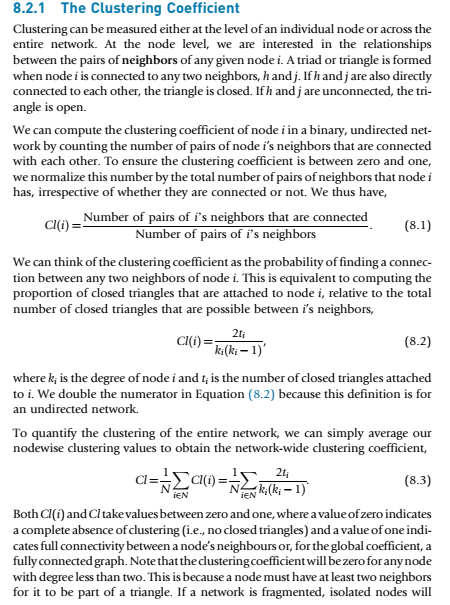

- The following function calculates clustering coeeficiency for individual neurons Cl(i) and CL of whole network for one file (one matrix). above it has been adopted to do it for many samples (many sheets of correlation matrix)

In [ ]:
# Clustering coefficient Cl (i) for individua neurons and Global Cl

import pandas as pd
import numpy as np



def clustering_coefficient(correlation_matrix):
    clustering_coefficients = {}
    total_triangles = 0
    
    #nodes = correlation_matrix.index
    #print (r'Nodes', nodes)
    num_nodes = correlation_matrix.shape[0]  # Number of rows in the matrix
    for neuron in range(num_nodes):
        neighbors = [n for n in range(num_nodes) if correlation_matrix[neuron, n] > 0 and n != neuron]
        ki = len(neighbors)  # Degree of the node
        ti = 0  # Number of closed triangles attached to the node
        
        if ki > 1:
            for i in range(ki):
                for j in range(i + 1, ki):
                    if correlation_matrix[neighbors[i], neighbors[j]] > 0:
                        ti += 1  # This triangle is counted once for each three nodes
        
        clustering_coefficients[neuron] = (2 * ti) / (ki * (ki - 1)) if ki > 1 else 0
        
        # Update total number of triangles
        total_triangles += ti

    # Calculate the sum of local clustering coefficients
    sum_local_clustering = sum(clustering_coefficients.values())
    
    # Calculate global clustering coefficient
    num_neurons = len(neuron_names)
    global_clustering = sum_local_clustering / num_nodes if num_nodes != 0 else 0
    
    return clustering_coefficients, global_clustering



# Load the Excel sheet containing the correlation matrix
excel_file = "Thresholded_Matrix_135_Ctrl_I3163_35DIV.raw_Threshold_0.1.xlsx"  # Replace with the path to your Excel file
data = pd.read_excel(excel_file, header=None)
neuron_names = data.iloc[1:, 0].values
# Create neuron index mapping
neuron_index_mapping = {name: index for index, name in enumerate(neuron_names)}
correlation_matrix = data.iloc[1:, 5:].values
np.fill_diagonal(correlation_matrix, 0)  # Replace NaN or diagonal values with 0
print(correlation_matrix)

# Calculate the clustering coefficient for each neuron and the global clustering coefficient
neuron_coefficients, global_clustering = clustering_coefficient(correlation_matrix)

# Calculate the average clustering coefficient across all neurons
average_clustering = sum(neuron_coefficients.values()) / len(neuron_coefficients)




# Create a DataFrame with neuron names as index and clustering coefficients as a column
clustering_df = pd.DataFrame.from_dict(neuron_coefficients, orient='index', columns=['Clustering Coefficient'])

# Add neuron names as a new column
clustering_df['Neuron'] = neuron_names

# Reorder columns to place 'Neuron' first
clustering_df = clustering_df[['Neuron', 'Clustering Coefficient']]

# Save the DataFrame to an Excel file
excel_output_file = 'clustering_coefficients.xlsx'
clustering_df.to_excel(excel_output_file, index=False)

print(f"Clustering Coefficients per Neuron (Excel file saved as '{excel_output_file}'):")
print(clustering_df)

print("\nGlobal Clustering Coefficient (Transitivity):", global_clustering)
print("Average Clustering Coefficient:", average_clustering)

'''
print("Clustering Coefficients per Neuron:")
for neuron, coefficient in neuron_coefficients.items():
    print(f"{neuron}: {coefficient}")

print("\nGlobal Clustering Coefficient (Transitivity):", global_clustering)
print("Average Clustering Coefficient:", average_clustering)
'''

# Global efficiency

- The code below measurs the efficieny based on inverse measure of shortest pathway.
- In case a node does not exist in the connections list the graph it will take 0 as its global efficiency

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd

# Load your data
excel_file = "Thresholded_Matrix_135_I3163_35DIV.raw_Threshold_0.6.xlsx"
data = pd.read_excel(excel_file)
neuron_names = data.iloc[:, 0].values
category = data.iloc[:, 4].values

# Sort correlation matrix based on neuron_names order
correlation_matrix = data.iloc[:, 5:].copy()
correlation_matrix.columns = neuron_names
correlation_matrix = correlation_matrix.reindex(neuron_names, axis=1)
correlation_matrix = correlation_matrix.reindex(neuron_names)

# Ensure diagonal is zero
np.fill_diagonal(correlation_matrix.values, 0)

# Create a weighted graph
G = nx.Graph()
for i, neuron_i in enumerate(neuron_names):
    for j, neuron_j in enumerate(neuron_names):
        if i < j:  # To avoid duplicates and self-loops
            correlation_coefficient = correlation_matrix.iloc[i, j]
            if correlation_coefficient > 0:  # Consider only positive correlations
                G.add_edge(neuron_i, neuron_j, weight=correlation_coefficient)

def efficiency_of_node(G, node):
    n = len(G.nodes)
    if node in G:
        shortest_path_lengths = nx.shortest_path_length(G, source=node, weight='weight')
        efficiency = sum(1 / length for length in shortest_path_lengths.values() if length != 0) / (n - 1)
        return efficiency
    else:
        return 0  # Return 0 if node is not found in the graph

# Calculate efficiency for each node
efficiencies = {node: efficiency_of_node(G, node) for node in neuron_names}

# Calculate average efficiency for each category
category_efficiencies = {}
for cat in set(category):
    cat_indices = [i for i, c in enumerate(category) if c == cat]
    cat_neurons = [neuron_names[i] for i in cat_indices]
    cat_efficiencies = [efficiencies[neuron] for neuron in cat_neurons]
    category_efficiencies[cat] = np.mean(cat_efficiencies)

# Export to Excel
output_file = "efficiency_data_1.xlsx"

# Create a DataFrame for node efficiencies
node_efficiency_df = pd.DataFrame({'Neuron': neuron_names, 'Efficiency': [efficiencies[node] for node in neuron_names]})
node_efficiency_df.to_excel(output_file, sheet_name='Node_Efficiencies', index=False)

# Append category average efficiencies to the same Excel file
with pd.ExcelWriter(output_file, engine='openpyxl', mode='a') as writer:
    category_efficiency_df = pd.DataFrame.from_dict(category_efficiencies, orient='index', columns=['Average_Efficiency'])
    category_efficiency_df.index.name = 'Category'
    category_efficiency_df.reset_index(inplace=True)
    category_efficiency_df.to_excel(writer, sheet_name='Category_Efficiencies', index=False)

print("Data exported successfully to efficiency_data.xlsx")